<a href="https://colab.research.google.com/github/datascisteven/greenflash_llm_project/blob/main/Greenflash_Toxicity_Multi_Class_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Authentication and Importing Necessary Libraries



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# prompt: authenticate with hugging face
from huggingface_hub import login

login()

In [ ]:
!pip install -q datasets transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (
    TensorDataset,
    DataLoader,
    RandomSampler,
    SequentialSampler,
    random_split,
)
from transformers import (
    BertTokenizer,
    BertModel,
    AdamW,
    get_linear_schedule_with_warmup,
)
import time
import datetime
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    precision_recall_curve,
    auc
)

import re
import warnings
warnings.filterwarnings("ignore")

from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# pd.set_option('display.width', 200)
# pd.set_option('display.max_colwidth', None)

import seaborn as sns
import matplotlib.pyplot as plt

# Importing Dataset



- All toxic comments are labeled as having ```'toxicity'``` = 1, as well as one of the following labels:
    - ```'obscene'```
    - ```'sexual_explicit'```
    - ```'insult'```
    - ```'threat'```
    - ```'identity_attack'```, which are further labeled with the following:
        - ```'gender'```: includes attacks categorized under Male and Female
        - ```'sexual_orientation'```: includes attacks categorized under Heterosexual, Homosexual (Gay or Lesbian), Bisexual, Transgender, Other Gender, and Other Sexual Orientation
        - ```'religion'```: includes Jewish, Muslim, Athiest, Hindu, Christian, Buddhist, and Other Religion
        - ```'ability'```: includes Physical Disability, Intellectual or Learning Disability, Psychiatric or Mental Illness, and Other Disability
        - ```'race'```: includes White, Black, Latino, Asian, and Other Race or Ethnicity


In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Projects/Greenflash/Toxicity/jigsaw_train_revised.csv', index_col=0)
dataset = dataset.drop(columns=['severe_toxicity'])
dataset.columns = ['id', 'comment_text', 'toxicity', 'obscene', 'sexual_explicit', 'identity_attack', 'insult', 'threat', 'ia_race', 'ia_gender', 'ia_sexual_orientation', 'ia_religion', 'ia_ability']
dataset = dataset[['id', 'comment_text', 'toxicity', 'obscene', 'sexual_explicit', 'insult', 'threat', 'identity_attack', 'ia_race', 'ia_gender', 'ia_sexual_orientation', 'ia_religion', 'ia_ability']]
dataset.head()

,id,comment_text,toxicity,obscene,sexual_explicit,insult,threat,identity_attack,ia_race,ia_gender,ia_sexual_orientation,ia_religion,ia_ability
0,1083994,He got his money... now he lies in wait till a...,0,0,0,0,0,0,0,0,0,0,0
1,650904,Mad dog will surely put the liberals in mental...,1,0,0,1,0,0,0,0,0,0,0
2,5902188,And Trump continues his lifelong cowardice by ...,1,0,0,1,0,0,0,0,0,0,0
4,5410943,Tucker and Paul are both total bad ass mofo's.,1,0,0,0,0,0,0,0,0,0,0
5,6290444,"Cry me a river, why don't you.\nDrinking, drug...",0,0,0,0,0,0,0,0,0,0,0


In [ ]:
dataset[['toxicity', 'obscene', 'sexual_explicit', 'insult', 'threat', 'identity_attack', 'ia_race', 'ia_gender', 'ia_sexual_orientation', 'ia_religion', 'ia_ability']].apply(lambda x: x.value_counts()).T

,0,1
toxicity,1698374,106438
obscene,1797164,7648
sexual_explicit,1801693,3119
insult,1724925,79887
threat,1802019,2793
identity_attack,1797179,7633
ia_race,1768565,36247
ia_gender,1730699,74113
ia_sexual_orientation,1792249,12563
ia_religion,1747018,57794


In [ ]:
len(dataset)

1804812

In [ ]:
dataset.toxicity.value_counts()

,count
toxicity,
0,1698374
1,106438


In [ ]:
non_toxic = dataset.loc[dataset.toxicity==0]
toxic = dataset.loc[dataset.toxicity==1]

non_toxic = non_toxic.sample(n=len(toxic), random_state=42)

dataset = pd.concat([non_toxic, toxic])
dataset.toxicity.value_counts()

,count
toxicity,
0,106438
1,106438


In [ ]:
value_counts = dataset[['toxicity', 'obscene', 'sexual_explicit', 'insult', 'threat', 'identity_attack', 'ia_race', 'ia_gender', 'ia_sexual_orientation', 'ia_religion', 'ia_ability']].apply(lambda x: x.value_counts()).T
value_counts['percentage'] = round(value_counts[1] / ((value_counts[0] + value_counts[1])) * 100, 2)
value_counts

,0,1,percentage
toxicity,106438,106438,50.00
obscene,205377,7499,3.52
sexual_explicit,210084,2792,1.31
insult,134658,78218,36.74
threat,210162,2714,1.27
identity_attack,205737,7139,3.35
ia_race,204169,8707,4.09
ia_gender,201222,11654,5.47
ia_sexual_orientation,209991,2885,1.36
ia_religion,204405,8471,3.98


In [ ]:
# Filter rows where the values in 'mixed_column' are not strings
non_string_rows = dataset[~dataset['comment_text'].apply(lambda x: isinstance(x, str))]

print(non_string_rows)

Empty DataFrame
Columns: [id, comment_text, toxicity, obscene, sexual_explicit, insult, threat, identity_attack, ia_race, ia_gender, ia_sexual_orientation, ia_religion, ia_ability]
Index: []


# Preparing Environment

In [ ]:
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    device = torch.device("cuda")
    print("Using GPU: ", torch.cuda.current_device())
else:
    device = torch.device("cpu")

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

Using GPU:  0


# Preparing Dataset

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

def get_dataset(df, tokenizer, mode="train"):
    sentences, labels = df["comment_text"], df.iloc[:, 2:].to_numpy()
    max_length = 300
    in_T = []
    in_T_attn_masks = []
    for sentence in sentences:
        enc_sent_dict = tokenizer.encode_plus(
            sentence[:300],
            max_length=max_length,
            add_special_tokens=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            truncation=True,
            return_tensors="pt",
        )
        in_T.append(enc_sent_dict["input_ids"])
        in_T_attn_masks.append(enc_sent_dict["attention_mask"])

    in_T = torch.cat(in_T, dim=0)
    in_T_attn_masks = torch.cat(in_T_attn_masks, dim=0)
    labels = torch.tensor(labels, dtype=torch.float32)
    print("Text Input: ", in_T.shape)
    print("Text Input Attention: ", in_T_attn_masks.shape)
    print("Labels: ", labels.shape)

    dataset = TensorDataset(in_T, in_T_attn_masks, labels)

    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    return train_dataset, val_dataset


train_dataset, val_dataset = get_dataset(
    dataset, tokenizer=tokenizer, mode="train"
)

batch_size = 8
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, sampler=RandomSampler(train_dataset)
)
val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size, sampler=SequentialSampler(val_dataset)
)

print("Data Ready!!")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Text Input:  torch.Size([212876, 300])
Text Input Attention:  torch.Size([212876, 300])
Labels:  torch.Size([212876, 11])
Data Ready!!


# Preparing Model

In [ ]:
class MultiTaskClassifier(nn.Module):
    def __init__(self, hidden_dim, num_labels):
        super(MultiTaskClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_labels = num_labels

        self.bertmodel = BertModel.from_pretrained("bert-base-uncased")
        self.ffn1 = nn.Linear(768, hidden_dim)
        self.dp1 = nn.Dropout()
        self.ffn2 = nn.Linear(hidden_dim, num_labels)

    def forward(self, in_T, in_T_attn_masks):
        hidden_states = self.bertmodel(in_T, in_T_attn_masks)[0]
        x = torch.mean(hidden_states, dim=1)
        x = F.relu(self.ffn1(x))
        x = self.dp1(x)
        x = torch.sigmoid(self.ffn2(x))
        return x


model = MultiTaskClassifier(100, 11).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
criterion = nn.BCELoss()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

# Training and Validation

In [ ]:
len(train_dataloader)

21288

In [ ]:
classes = ['toxic',
            'obscene',
            'sexually explicit',
            'insult',
            'threat',
            'identity attack',
            'IA: race and ethnicity',
            'IA: gender',
            'IA: sexual orientation and gender identity',
            'IA: religion',
            'IA: disability']

In [16]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

epochs = 5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

training_stats = []
total_t0 = time.time()

best_val_loss = 1e8

true_labels = torch.cat([batch[2] for batch in val_dataloader]).numpy()

for epoch in range(0, epochs):

    print(f"\n======== Epoch {epoch + 1} / {epochs} ========")
    print("Training...")

    t0 = time.time()
    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print(f" Batch {step:>5,}  of  {len(train_dataloader):>5,}. Elapsed: {elapsed}. Loss: {total_train_loss / step:.5f}")

        b_in_T = batch[0].to(device)
        b_in_T_attn_masks = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        logits = model(b_in_T, b_in_T_attn_masks)
        loss = criterion(logits, b_labels)

        total_train_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print(f"\n  Average training loss: {avg_train_loss:.2f}")
    print(f"  Training epoch took: {training_time}")

    print("\nRunning Validation...")

    t0 = time.time()
    model.eval()

    total_eval_loss = 0
    pred_probabilities = np.empty((0, 11))

    for batch in val_dataloader:
        b_in_T = batch[0].to(device)
        b_in_T_attn_masks = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            logits = model(b_in_T, b_in_T_attn_masks)
            loss = criterion(logits, b_labels)

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        pred_probabilities = np.concatenate((pred_probabilities, logits), axis=0)

    avg_val_loss = total_eval_loss / len(val_dataloader)
    validation_time = format_time(time.time() - t0)

    pred_labels = np.array(
        [[int(x >= 0.25) for x in pred_probabilities[:, i]] for i in range(11)]
    ).transpose()

    print(f"  Validation Loss: {avg_val_loss:.2f}")
    print(f"  Validation took: {validation_time}")

    for i in range(11):

        true_class_labels = true_labels[:, i]
        pred_class_probs = pred_probabilities[:, i]

        try:
            roc_auc = roc_auc_score(true_class_labels, pred_class_probs)
        except ValueError:
            roc_auc = float('nan')

        precision, recall, _ = precision_recall_curve(true_class_labels, pred_class_probs)
        pr_auc = auc(recall, precision)


        print(f"Class {i + 1}: ")
        print(f"    Class {i + 1} ROC AUC: {roc_auc:.2f}")
        print(f"    Class {i + 1} PR AUC: {pr_auc:.2f}")
        print(f"    Class {i + 1} Accuracy: {accuracy_score(true_labels[:, i], pred_labels[:, i]):.2f}")
        print(f"    Class {i + 1} Macro F1-score: {f1_score(true_labels[:, i], pred_labels[:, i], average='macro'):.2f}")
        print(f"    Class {i + 1} Weighted F1-score: {f1_score(true_labels[:, i], pred_labels[:, i], average='weighted'):.2f}")
        print(f"    Class {i + 1} Precision: {precision_score(true_labels[:, i], pred_labels[:, i]):.2f}")
        print(f"    Class {i + 1} Recall: {recall_score(true_labels[:, i], pred_labels[:, i]):.2f}")


    training_stats.append(
        {
            "epoch": epoch + 1,
            "training_loss": avg_train_loss,
            "avg_val_loss": avg_val_loss,
            "avg_val_accuracy": np.mean([accuracy_score(true_labels[:, i], pred_labels[:, i]) for i in range(11)]),
            "avg_val_macro_f1": np.mean([f1_score(true_labels[:, i], pred_labels[:, i], average="macro") for i in range(11)]),
            "avg_val_weighted_f1": np.mean([f1_score(true_labels[:, i], pred_labels[:, i], average="weighted") for i in range(11)]),
            "avy_val_roc_auc": np.nanmean([roc_auc_score(true_labels[:, i], pred_probabilities[:, i]) if len(np.unique(true_labels[:, i])) > 1 else float('nan') for i in range(11)]),
            "avg_val_pr_auc": np.mean([auc(precision_recall_curve(true_labels[:, i], pred_probabilities[:, i])[1], precision_recall_curve(true_labels[:, i], pred_probabilities[:, i])[0]) for i in range(11)]),
            "training_time": training_time,
            "val_time": validation_time,
            for i in range(11):
                f"val_accuracy_class_{i + 1}": accuracy_score(true_labels[:, i], pred_labels[:, i]),
                f"val_macro_f1_class_{i + 1}": f1_score(true_labels[:, i], pred_labels[:, i], average="macro"),
                f"val_weighted_f1_class_{i + 1}": f1_score(true_labels[:, i], pred_labels[:, i], average="weighted"),
                f"val_precision_class_{i + 1}": precision_score(true_labels[:, i], pred_labels[:, i]),
                f"val_recall_class_{i + 1}": recall_score(true_labels[:, i], pred_labels[:, i]),
                f"val_roc_auc_class_{i + 1}": roc_auc_score(true_labels[:, i], pred_probabilities[:, i]),
                f"val_pr_auc_class_{i + 1}": auc(precision_recall_curve(true_labels[:, i], pred_probabilities[:, i])[1], precision_recall_curve(true_labels[:, i], pred_probabilities[:, i])[0])
        }
    )

    model_path = f"toxicity_multi_class_state_dict_epoch_{epoch + 1}.pt"
    torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'avg_val_loss': avg_val_loss,
            }, model_path)

    command = f"cp -r /content/toxicity_multi_class_state_dict_epoch_{epoch + 1}.pt /content/drive/MyDrive/Projects/Greenflash/toxicity_multi_class_state_dict_epoch_{epoch + 1}.pt"
    os.system(command)


print("")
stats_path = "toxicity_multi_class_training_stats_pickle"
pd.DataFrame(training_stats).to_pickle(stats_path)
!cp -r /content/toxicity_multi_class_training_stats_pickle /content/drive/MyDrive/Projects/Greenflash/toxicity_multi_class_training_stats_pickle


model_path = "toxicity_multi_class.pth"
torch.save(model, model_path)
!cp -r /content/toxicity_multi_class.pth /content/drive/MyDrive/Projects/Greenflash/toxicity_multi_class.pth


print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time() - total_t0)))


======== Epoch 1 / 5 ========
Training...
 Batch   500  of  21,288. Elapsed: 0:01:30. Loss: 0.28553
 Batch 1,000  of  21,288. Elapsed: 0:03:01. Loss: 0.23892
 Batch 1,500  of  21,288. Elapsed: 0:04:34. Loss: 0.20964
 Batch 2,000  of  21,288. Elapsed: 0:06:07. Loss: 0.19397
 Batch 2,500  of  21,288. Elapsed: 0:07:41. Loss: 0.18163
 Batch 3,000  of  21,288. Elapsed: 0:09:15. Loss: 0.17253
 Batch 3,500  of  21,288. Elapsed: 0:10:48. Loss: 0.16572
 Batch 4,000  of  21,288. Elapsed: 0:12:22. Loss: 0.16017
 Batch 4,500  of  21,288. Elapsed: 0:13:56. Loss: 0.15526
 Batch 5,000  of  21,288. Elapsed: 0:15:30. Loss: 0.15125
 Batch 5,500  of  21,288. Elapsed: 0:17:03. Loss: 0.14773
 Batch 6,000  of  21,288. Elapsed: 0:18:37. Loss: 0.14463
 Batch 6,500  of  21,288. Elapsed: 0:20:11. Loss: 0.14167
 Batch 7,000  of  21,288. Elapsed: 0:21:45. Loss: 0.13921
 Batch 7,500  of  21,288. Elapsed: 0:23:18. Loss: 0.13720
 Batch 8,000  of  21,288. Elapsed: 0:24:52. Loss: 0.13503
 Batch 8,500  of  21,288. Ela

In [18]:
stats_path = "toxicity_training_stats_pickle"
pd.DataFrame(training_stats).to_pickle(stats_path)
!cp -r /content/toxicity_training_stats_pickle /content/drive/MyDrive/Projects/Greenflash/toxicity_training_stats_pickle

In [23]:
stats_path = "/content/drive/MyDrive/Projects/Greenflash/toxicity_multi_class_training_stats_pickle"
training_stats = pd.read_pickle(stats_path)

stats = pd.DataFrame(training_stats)


In [25]:
columns = ['Epoch',
           'Training Loss',
           'Average Validation Loss',
           'Average Validation Accuracy',
           'Average Validation Macro-F1 Score',
           'Average Validation Weighted-F1 Score',
           'Average Validation ROC-AUC Score',
           'Average Validation PR-AUC Score',
           'Training Time',
           'Validation Time',
           'Validation Accuracy: toxic',
           'Validation Macro F1: toxic',
           'Validation Precision: toxic',
           'Validation Recall: toxic',
           'Validation ROC-AUC: toxic',
           'Validation PR-AUC: toxic',
           'Validation Accuracy: obscene',
           'Validation Macro F1: obscene',
           'Validation Precision: obscene',
           'Validation Recall: obscene',
           'Validation ROC-AUC: obscene',
           'Validation PR-AUC: obscene',
           'Validation Accuracy: sexually explicit',
           'Validation Macro F1: sexually explicit',
           'Validation Precision: sexually explicit',
           'Validation Recall: sexually explicit',
           'Validation ROC-AUC: sexually explicit',
           'Validation PR-AUC: sexually explicit',
           'Validation Accuracy: insult',
           'Validation Macro F1: insult',
           'Validation Precision: insult',
           'Validation Recall: insult',
           'Validation ROC-AUC: insult',
           'Validation PR-AUC: insult',
           'Validation Accuracy: threat',
           'Validation Macro F1: threat',
           'Validation Precision: threat',
           'Validation Recall: threat',
           'Validation ROC-AUC: threat',
           'Validation PR-AUC: threat',
           'Validation Accuracy: identity attack',
           'Validation Macro F1: identity attack',
           'Validation Precision: identity attack',
           'Validation Recall: identity attack',
           'Validation ROC-AUC: identity attack',
           'Validation PR-AUC: identity attack',
           'Validation Accuracy: IA - race/ethnicity',
           'Validation Macro F1: IA - race/ethnicity',
           'Validation Precision: IA - race/ethnicity',
           'Validation Recall: IA - race/ethnicity',
           'Validation ROC-AUC: IA - race/ethnicity',
           'Validation PR-AUC: IA - race/ethnicity',
           'Validation Accuracy: IA - gender',
           'Validation Macro F1: IA - gender',
           'Validation Precision: IA - gender',
           'Validation Recall: IA - gender',
           'Validation ROC-AUC: IA - gender',
           'Validation PR-AUC: IA - gender',
           'Validation Accuracy: IA - sexual orientation/gender identity',
           'Validation Macro F1: IA - sexual orientation/gender identity',
           'Validation Precision: IA - sexual orientation/gender identity',
           'Validation Recall: IA - sexual orientation/gender identity',
           'Validation ROC-AUC: IA - sexual orientation/gender identity',
           'Validation PR-AUC: IA - sexual orientation/gender identity',
           'Validation Accuracy: IA - religion',
           'Validation Macro F1: IA - religion',
           'Validation Precision: IA - religion',
           'Validation Recall: IA - religion',
           'Validation ROC-AUC: IA - religion',
           'Validation PR-AUC: IA - religion',
           'Validation Accuracy: IA - disability',
           'Validation Macro F1: IA - disability',
           'Validation Precision: IA - disability',
           'Validation Recall: IA - disability',
           'Validation ROC-AUC: IA - disability',
           'Validation PR-AUC: IA - disability']

stats.columns = columns
stats.T


,0,1,2,3,4
Epoch,1,2,3,4,5
Training Loss,0.112459,0.082107,0.065133,0.049419,0.037296
Average Validation Loss,0.087081,0.085602,0.092653,0.118624,0.134507
Average Validation Accuracy,0.963332,0.964824,0.965044,0.965909,0.965416
Average Validation Macro-F1 Score,0.856676,0.864718,0.866772,0.867301,0.866504
Average Validation Weighted-F1 Score,0.963387,0.965034,0.965331,0.966117,0.965678
Average Validation ROC-AUC Score,0.966688,0.968279,0.966103,0.961938,0.959683
Average Validation PR-AUC Score,0.780677,0.795824,0.796097,0.783343,0.778278
Training Time,1:06:26,1:06:28,1:05:40,1:06:02,1:06:09
Validation Time,0:05:07,0:05:06,0:05:01,0:05:07,0:05:06


# Inference


## Loading and Preprocessing Dataset

In [26]:
all_data = pd.read_csv('/content/drive/MyDrive/Projects/Greenflash/Toxicity/jigsaw-unintended-bias-in-toxicity-classification/all_data.csv')
all_data.head()

,id,comment_text,split,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,toxicity,severe_toxicity,obscene,sexual_explicit,identity_attack,insult,threat,male,female,transgender,other_gender,heterosexual,homosexual_gay_or_lesbian,bisexual,other_sexual_orientation,christian,jewish,muslim,hindu,buddhist,atheist,other_religion,black,white,asian,latino,other_race_or_ethnicity,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability,identity_annotator_count,toxicity_annotator_count
0,1083994,He got his money... now he lies in wait till a...,train,2017-03-06 15:21:53.675241+00,21,NaN,317120,approved,0,0,0,2,0,0.373134,0.044776,0.089552,0.014925,0.000000,0.343284,0.014925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,67
1,650904,Mad dog will surely put the liberals in mental...,train,2016-12-02 16:44:21.329535+00,21,NaN,154086,approved,0,0,1,2,0,0.605263,0.013158,0.065789,0.013158,0.092105,0.565789,0.065789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,76
2,5902188,And Trump continues his lifelong cowardice by ...,train,2017-09-05 19:05:32.341360+00,55,NaN,374342,approved,1,0,2,3,7,0.666667,0.015873,0.031746,0.000000,0.047619,0.666667,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,63
3,7084460,"""while arresting a man for resisting arrest"".\...",test,2016-11-01 16:53:33.561631+00,13,NaN,149218,approved,0,0,0,0,0,0.815789,0.065789,0.552632,0.592105,0.000000,0.684211,0.105263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,76
4,5410943,Tucker and Paul are both total bad ass mofo's.,train,2017-06-14 05:08:21.997315+00,21,NaN,344096,approved,0,0,0,1,0,0.550000,0.037500,0.337500,0.275000,0.037500,0.487500,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,80


In [30]:
test_data = all_data.loc[all_data.split=='test']

test_data[1] = np.where(test_data.toxicity > 0.5, 1, 0)
test_data[2] = np.where(test_data.obscene > 0.5, 1, 0)
test_data[3] = np.where(test_data.sexual_explicit > 0.5, 1, 0)
test_data[4] = np.where(test_data.insult > 0.5, 1, 0)
test_data[5] = np.where(test_data.threat > 0.5, 1, 0)
test_data[6] = np.where(test_data.identity_attack > 0.5, 1, 0)
test_data[7] = np.where(test_data.male > 0.5, 1, 0)
test_data[8] = np.where(test_data.female > 0.5, 1, 0)
test_data[9] = np.where(test_data.transgender > 0.5, 1, 0)
test_data[10] = np.where(test_data.other_gender > 0.5, 1, 0)
test_data[11] = np.where(test_data.heterosexual > 0.5, 1, 0)
test_data[12] = np.where(test_data.homosexual_gay_or_lesbian > 0.5, 1, 0)
test_data[13] = np.where(test_data.bisexual > 0.5, 1, 0)
test_data[14] = np.where(test_data.other_sexual_orientation > 0.5, 1, 0)
test_data[15] = np.where(test_data.christian > 0.5, 1, 0)
test_data[16] = np.where(test_data.jewish > 0.5, 1, 0)
test_data[17] = np.where(test_data.muslim > 0.5, 1, 0)
test_data[18] = np.where(test_data.hindu > 0.5, 1, 0)
test_data[19] = np.where(test_data.buddhist > 0.5, 1, 0)
test_data[20] = np.where(test_data.atheist > 0.5, 1, 0)
test_data[21] = np.where(test_data.other_religion > 0.5, 1, 0)
test_data[22] = np.where(test_data.black > 0.5, 1, 0)
test_data[23] = np.where(test_data.white > 0.5, 1, 0)
test_data[24] = np.where(test_data.asian > 0.5, 1, 0)
test_data[25] = np.where(test_data.latino > 0.5, 1, 0)
test_data[26] = np.where(test_data.other_race_or_ethnicity > 0.5, 1, 0)
test_data[27] = np.where(test_data.physical_disability > 0.5, 1, 0)
test_data[28] = np.where(test_data.intellectual_or_learning_disability > 0.5, 1, 0)
test_data[29] = np.where(test_data.psychiatric_or_mental_illness > 0.5, 1, 0)
test_data[30] = np.where(test_data.other_disability > 0.5, 1, 0)


columns = ['toxicity',
           'obscene',
           'sexual_explicit',
           'insult',
           'threat',
           'identity_attack',
           'male',
           'female',
           'transgender',
           'other_gender',
           'heterosexual',
           'homosexual_gay_or_lesbian',
           'bisexual',
           'other_sexual_orientation',
           'christian',
           'jewish',
           'muslim',
           'hindu',
           'buddhist',
           'atheist',
           'other_religion',
           'black',
           'white',
           'asian',
           'latino',
           'other_race_or_ethnicity',
           'physical_disability',
           'intellectual_or_learning_disability',
           'psychiatric_or_mental_illness',
           'other_disability']

test_data = test_data.drop(columns=columns)

test_js = pd.concat([test_data[['id', 'comment_text']], test_data.iloc[:, -30:]], axis=1)
test_js.columns = ['id', 'comment_text'] + columns

test_js['race'] = test_js[['asian', 'black', 'latino', 'other_race_or_ethnicity', 'white']].sum(axis=1)
test_js['gender'] = test_js[['female', 'male']].sum(axis=1)
test_js['sexual_orientation'] = test_js[['bisexual', 'heterosexual', 'homosexual_gay_or_lesbian', 'transgender', 'other_sexual_orientation', 'other_gender']].sum(axis=1)
test_js['religion'] = test_js[['atheist', 'buddhist', 'christian', 'hindu', 'jewish', 'muslim', 'other_religion']].sum(axis=1)
test_js['ability'] = test_js[['physical_disability', 'intellectual_or_learning_disability', 'psychiatric_or_mental_illness', 'other_disability']].sum(axis=1)

tt_js = pd.concat([test_js.iloc[:, :8], test_js.iloc[:, -5:]], axis=1)

tt_js['race'] = tt_js.race.replace(2, 1).replace(3, 1).replace(4, 1).replace(5, 1).replace(6, 1)
tt_js['gender'] = tt_js.gender.replace(2, 1). replace(3, 1)
tt_js['sexual_orientation'] = tt_js.sexual_orientation.replace(2, 1).replace(3, 1).replace(4, 1).replace(5, 1)
tt_js['religion'] = tt_js.religion.replace(2, 1).replace(3, 1).replace(4, 1).replace(5, 1).replace(6, 1)
tt_js['ability'] = tt_js.ability.replace(2, 1).replace(3, 1).replace(4, 1)

test_df = tt_js.set_index('id')
test_df.head()

,comment_text,toxicity,obscene,sexual_explicit,insult,threat,identity_attack,race,gender,sexual_orientation,religion,ability
id,,,,,,,,,,,,
7084460,"""while arresting a man for resisting arrest"".\...",1,1,1,1,0,0,0,0,0,0,0
7141509,NO ! There are no alternative facts. Go check...,1,0,0,1,0,0,0,0,0,0,0
7077814,the more you whine sore loser Artster\n\nthe m...,1,0,0,1,0,0,0,0,0,0,0
7147990,There's rarely opportunity to agree with Benne...,0,0,0,0,0,0,0,0,0,0,0
7008066,The Law has every freedom to be an asss!,1,0,0,0,0,0,0,0,0,0,0


In [32]:
test_df.toxicity.value_counts()

,count
toxicity,
0,183204
1,11437


## Preparing Dataset for Model

In [33]:
def prepare_test_data(test_df, tokenizer):
    sentences = test_df["comment_text"]
    max_length = 300
    in_T = []
    in_T_attn_masks = []

    for sentence in sentences:
        enc_sent_dict = tokenizer.encode_plus(
            sentence[:300],
            max_length=max_length,
            add_special_tokens=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            truncation=True,
            return_tensors="pt",
        )
        in_T.append(enc_sent_dict["input_ids"])
        in_T_attn_masks.append(enc_sent_dict["attention_mask"])

    in_T = torch.cat(in_T, dim=0)
    in_T_attn_masks = torch.cat(in_T_attn_masks, dim=0)
    print("Text Input: ", in_T.shape)
    print("Text Input Attention: ", in_T_attn_masks.shape)

    dataset = TensorDataset(in_T, in_T_attn_masks)
    return dataset

test_dataset = prepare_test_data(test_df, tokenizer)

test_dataloader = DataLoader(test_dataset, batch_size=8, sampler=SequentialSampler(test_dataset))

Text Input:  torch.Size([194641, 300])
Text Input Attention:  torch.Size([194641, 300])


## Loading Model

In [34]:
model = torch.load('/content/drive/MyDrive/Projects/Greenflash/toxicity_multi_class.pth')
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MultiTaskClassifier(
  (bertmodel): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

In [36]:
predictions = []
with torch.no_grad():
    for batch in test_dataloader:
        b_in_T = batch[0].to(device)
        b_in_T_attn_masks = batch[1].to(device)

        logits = model(b_in_T, b_in_T_attn_masks)
        probs = torch.sigmoid(logits)
        predictions.append(probs.cpu().numpy())

predictions = np.vstack(predictions)

threshold = 0.25
binary_predictions = (predictions >= threshold).astype(int)


## Model Evaluation and Threshold-Moving

In [37]:
true_labels = test_df.iloc[:, 1:].to_numpy()
true_labels = np.array(true_labels)

assert true_labels.shape == binary_predictions.shape, "Shape mismatch between true labels and predictions"

In [39]:
def find_best_thresholds(true_labels, predictions, metric, metric_name):
    thresholds = np.arange(0.0, 1.0, 0.01)
    best_thresholds = []

    for i in range(true_labels.shape[1]):
        best_threshold = 0.5
        best_metric_score = -1

        for threshold in thresholds:
            binary_predictions = (predictions[:, i] >= threshold).astype(int)
            score = metric(true_labels[:, i], binary_predictions)

            if score > best_metric_score:
                best_metric_score = score
                best_threshold = threshold

        best_thresholds.append(best_threshold)
        print(f"Best threshold for label {i + 1}: {best_threshold:.2f}, Best {metric_name}: {best_metric_score:.2f}")

    return np.array(best_thresholds)

In [40]:
best_thresholds_f1 = find_best_thresholds(true_labels, predictions, f1_score, 'F1 Score')

binary_predictions_f1 = np.zeros_like(predictions)

for i in range(predictions.shape[1]):
    binary_predictions_f1[:, i] = (predictions[:, i] >= best_thresholds_f1[i]).astype(int)

Best threshold for label 1: 0.73, Best F1 Score: 0.61
Best threshold for label 2: 0.67, Best F1 Score: 0.59
Best threshold for label 3: 0.66, Best F1 Score: 0.50
Best threshold for label 4: 0.72, Best F1 Score: 0.62
Best threshold for label 5: 0.68, Best F1 Score: 0.42
Best threshold for label 6: 0.67, Best F1 Score: 0.37
Best threshold for label 7: 0.69, Best F1 Score: 0.80
Best threshold for label 8: 0.68, Best F1 Score: 0.78
Best threshold for label 9: 0.64, Best F1 Score: 0.83
Best threshold for label 10: 0.69, Best F1 Score: 0.81
Best threshold for label 11: 0.58, Best F1 Score: 0.63


In [41]:
best_thresholds_precision = find_best_thresholds(true_labels, predictions, precision_score, 'Precision')

binary_predictions_precision = np.zeros_like(predictions)

for i in range(predictions.shape[1]):
    binary_predictions_precision[:, i] = (predictions[:, i] >= best_thresholds_precision[i]).astype(int)

Best threshold for label 1: 0.73, Best Precision: 0.56
Best threshold for label 2: 0.72, Best Precision: 0.76
Best threshold for label 3: 0.72, Best Precision: 0.60
Best threshold for label 4: 0.73, Best Precision: 0.75
Best threshold for label 5: 0.72, Best Precision: 0.43
Best threshold for label 6: 0.72, Best Precision: 0.47
Best threshold for label 7: 0.73, Best Precision: 0.97
Best threshold for label 8: 0.73, Best Precision: 0.95
Best threshold for label 9: 0.72, Best Precision: 0.95
Best threshold for label 10: 0.73, Best Precision: 0.99
Best threshold for label 11: 0.71, Best Precision: 0.90


In [42]:
best_thresholds_recall = find_best_thresholds(true_labels, predictions, recall_score, 'Recall')

binary_predictions_recall = np.zeros_like(predictions)

for i in range(predictions.shape[1]):
    binary_predictions_recall[:, i] = (predictions[:, i] >= best_thresholds_recall[i]).astype(int)

Best threshold for label 1: 0.00, Best Recall: 1.00
Best threshold for label 2: 0.00, Best Recall: 1.00
Best threshold for label 3: 0.00, Best Recall: 1.00
Best threshold for label 4: 0.00, Best Recall: 1.00
Best threshold for label 5: 0.00, Best Recall: 1.00
Best threshold for label 6: 0.00, Best Recall: 1.00
Best threshold for label 7: 0.00, Best Recall: 1.00
Best threshold for label 8: 0.00, Best Recall: 1.00
Best threshold for label 9: 0.00, Best Recall: 1.00
Best threshold for label 10: 0.00, Best Recall: 1.00
Best threshold for label 11: 0.00, Best Recall: 1.00


In [43]:
def find_best_thresholds(true_labels, predictions):
    thresholds = np.arange(0.0, 1.0, 0.01)
    best_thresholds = []

    for i in range(true_labels.shape[1]):
        best_threshold = 0.5
        best_auc = -1  # Start with a low value for PR-AUC score

        # For each threshold, compute the PR-AUC
        for threshold in thresholds:
            binary_predictions = (predictions[:, i] >= threshold).astype(int)

            # Calculate precision and recall for the current threshold
            precision, recall, _ = precision_recall_curve(true_labels[:, i], binary_predictions)

            # Calculate PR-AUC
            pr_auc = auc(recall, precision)

            if pr_auc > best_auc:
                best_auc = pr_auc
                best_threshold = threshold

        best_thresholds.append(best_threshold)
        print(f"Best threshold for label {i + 1}: {best_threshold:.2f}, Best PR-AUC: {best_auc:.2f}")

    return np.array(best_thresholds)

# Example usage
best_thresholds_pr_auc = find_best_thresholds(true_labels, predictions)

# Apply the best thresholds to binary predictions
binary_predictions_pr_auc = np.zeros_like(predictions)

for i in range(predictions.shape[1]):
    binary_predictions_pr_auc[:, i] = (predictions[:, i] >= best_thresholds_pr_auc[i]).astype(int)

Best threshold for label 1: 0.73, Best PR-AUC: 0.62
Best threshold for label 2: 0.67, Best PR-AUC: 0.59
Best threshold for label 3: 0.61, Best PR-AUC: 0.52
Best threshold for label 4: 0.72, Best PR-AUC: 0.64
Best threshold for label 5: 0.00, Best PR-AUC: 0.50
Best threshold for label 6: 0.00, Best PR-AUC: 0.50
Best threshold for label 7: 0.69, Best PR-AUC: 0.81
Best threshold for label 8: 0.70, Best PR-AUC: 0.79
Best threshold for label 9: 0.66, Best PR-AUC: 0.83
Best threshold for label 10: 0.71, Best PR-AUC: 0.82
Best threshold for label 11: 0.58, Best PR-AUC: 0.63


In [49]:
prediction_labels = ['Toxic',
                     'Obscene',
                     'Sexually Explicit',
                     'Insult',
                     'Threat',
                     'Identity Attack',
                     'IA: Race/Ethnicity',
                     'IA: Gender',
                     'IA: Sexual Orientation/Gender Identity',
                     'IA: Religion',
                     'IA: Disability']

# Confusion Matrices

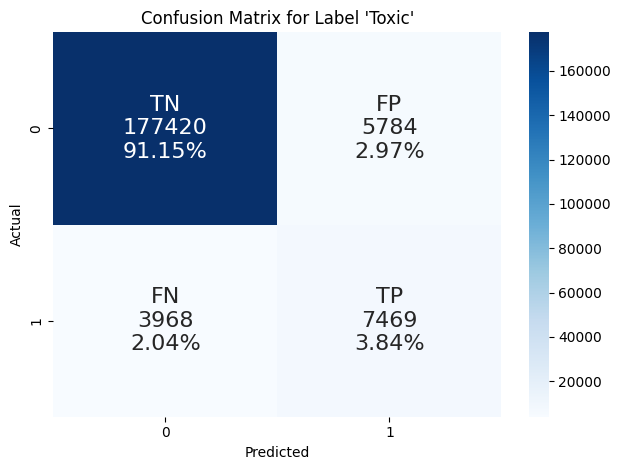

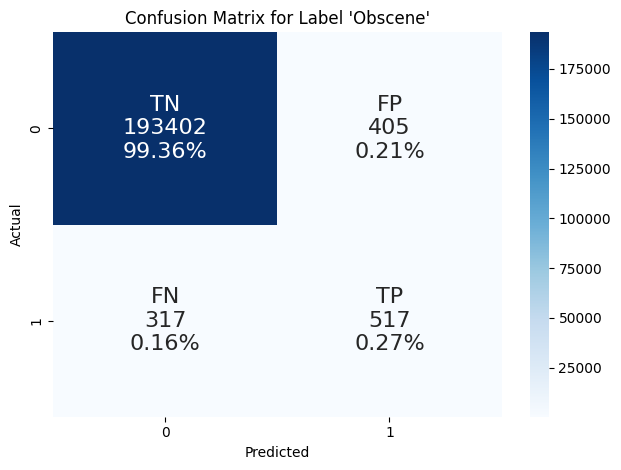

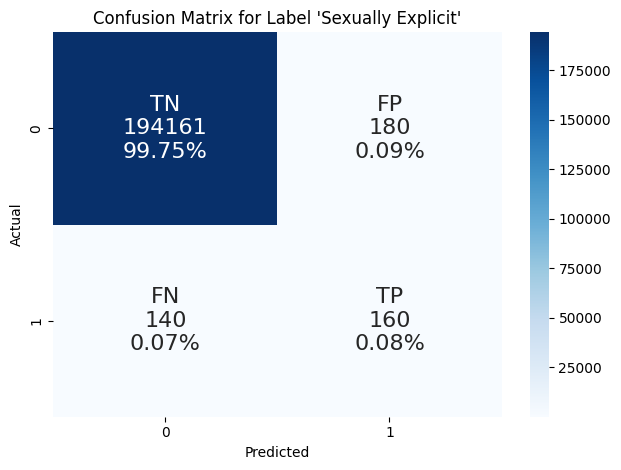

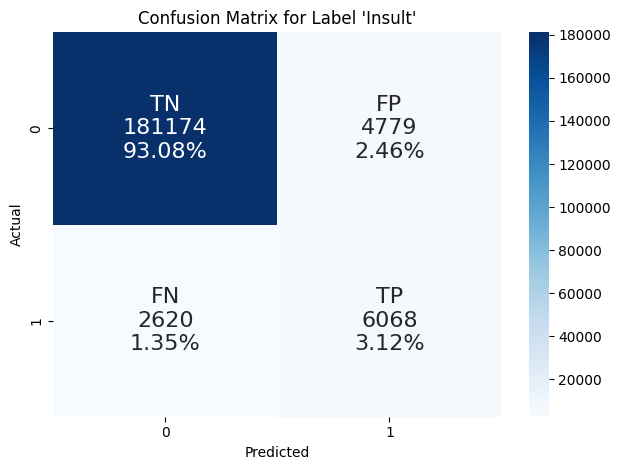

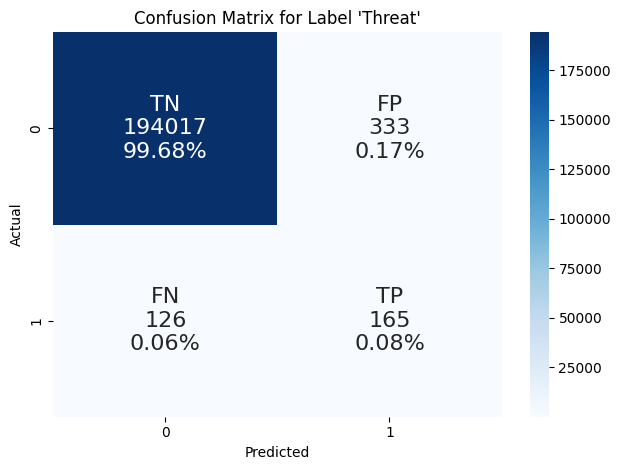

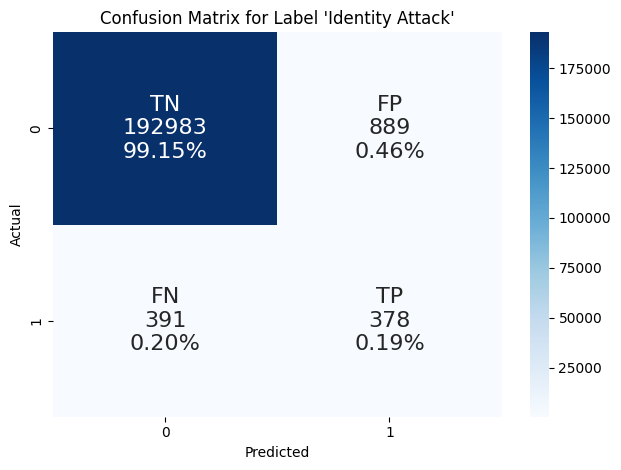

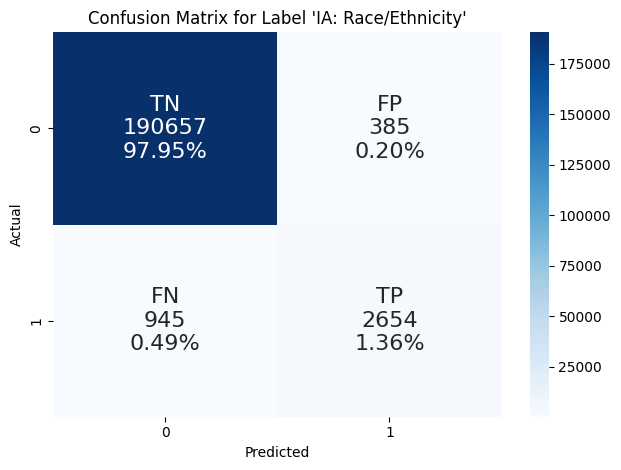

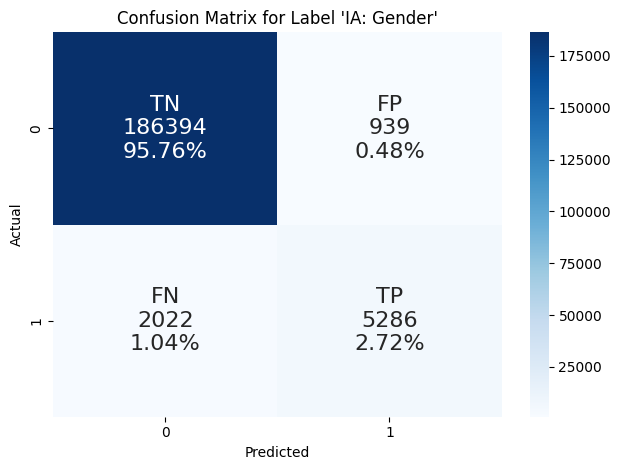

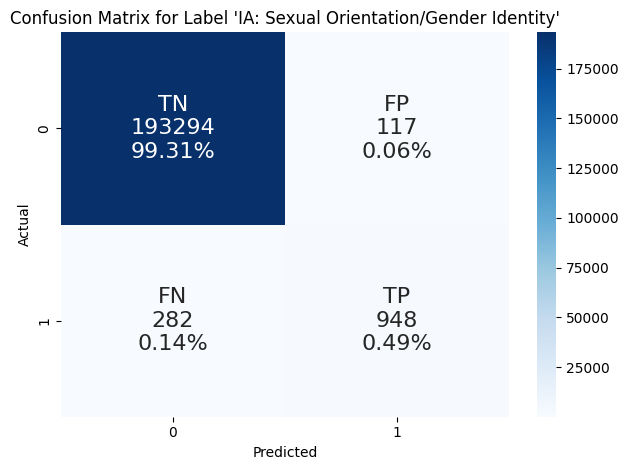

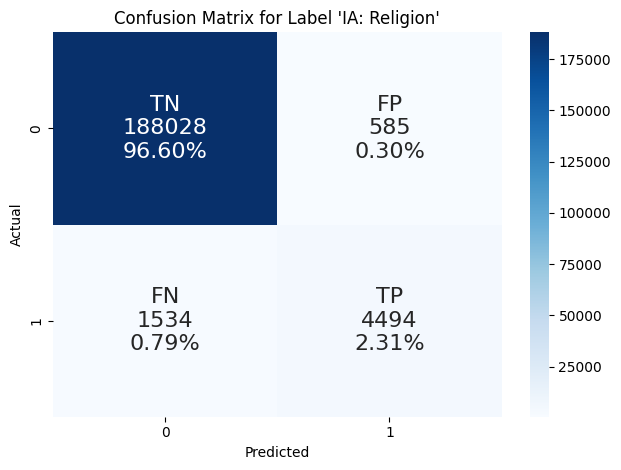

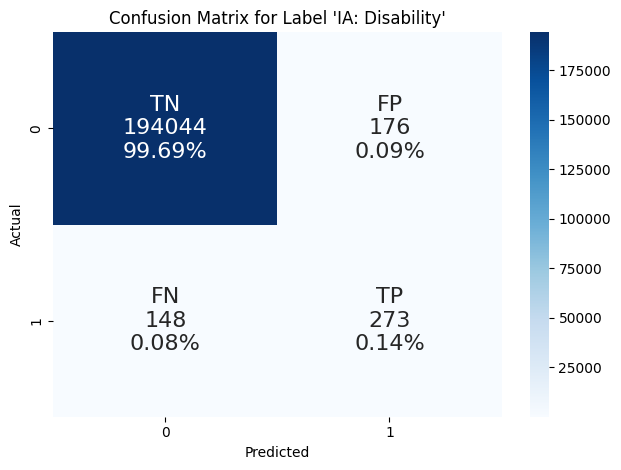

In [50]:
def plot_confusion_matrices(true_labels, predictions):
    # Loop over each label and create a confusion matrix
    for i in range(11):
        # Compute confusion matrix for label i
        cnf = confusion_matrix(true_labels[:, i], predictions[:, i])
        group_names = ['TN','FP','FN','TP']
        group_counts = ['{0:0.0f}'.format(value) for value in cnf.flatten()]
        group_percentages = ['{0:.2%}'.format(value) for value in cnf.flatten()/np.sum(cnf)]
        labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
        labels = np.asarray(labels).reshape(2,2)

        # Plot confusion matrix as a heatmap
        sns.heatmap(cnf, annot=labels, fmt='', cmap='Blues', annot_kws={'size':16})
        plt.title(f"Confusion Matrix for Label '{prediction_labels[i]}'")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()

        # Show the plot
        plt.show()

# Call the function to plot confusion matrices for all 12 labels
plot_confusion_matrices(true_labels, binary_predictions_f1)

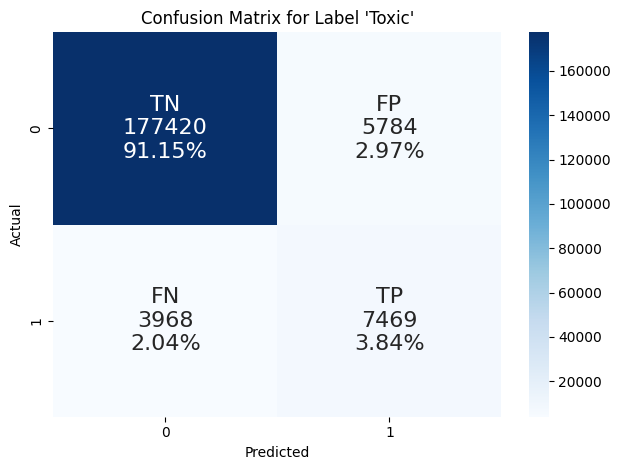

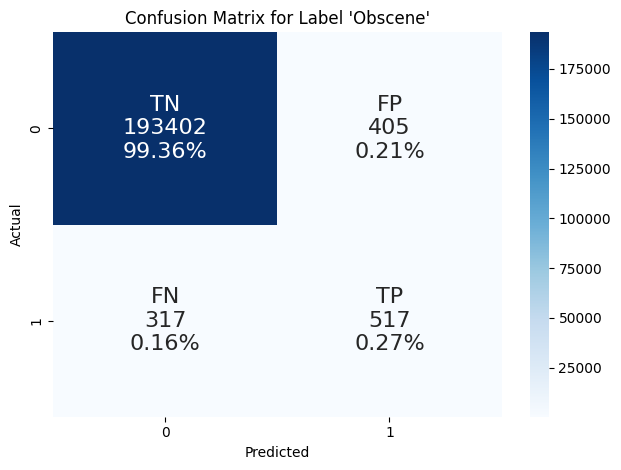

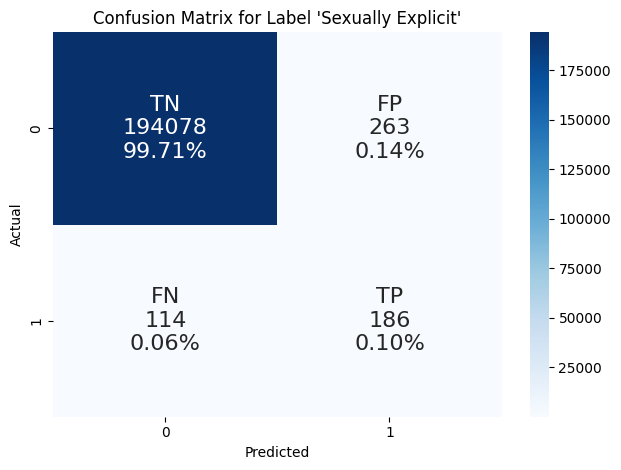

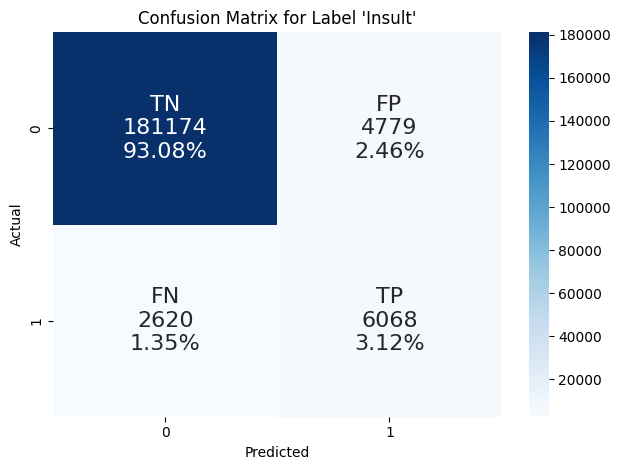

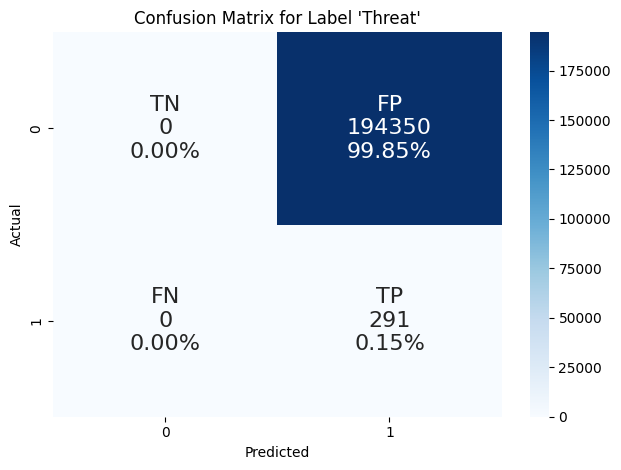

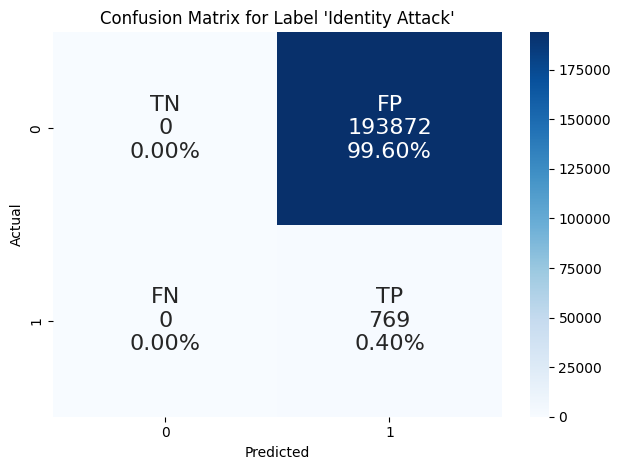

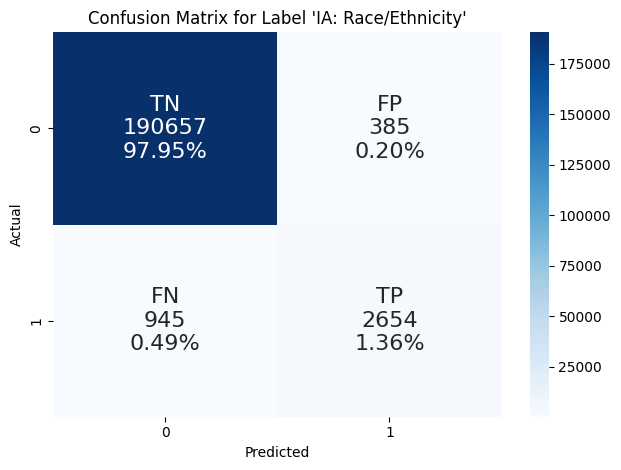

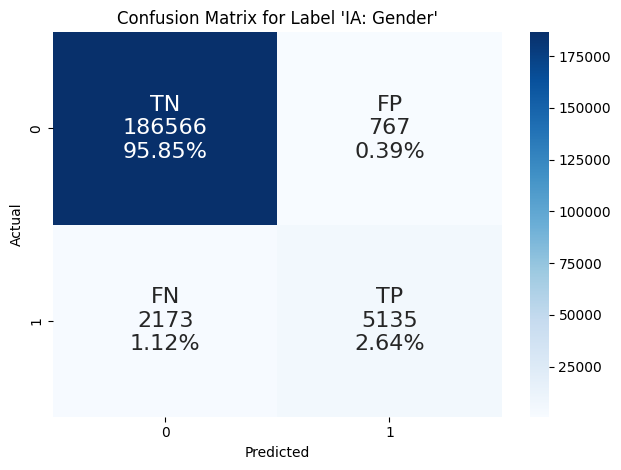

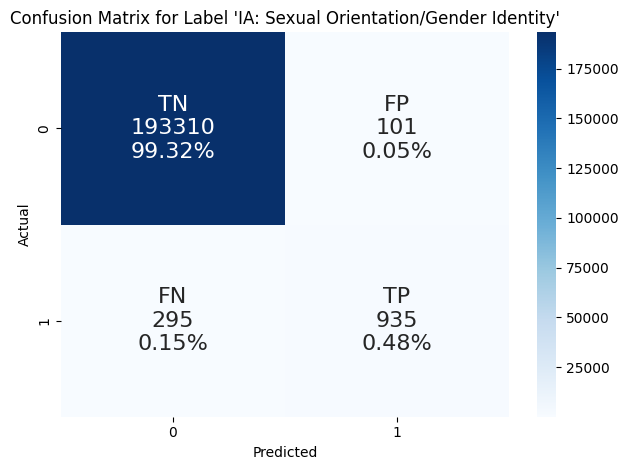

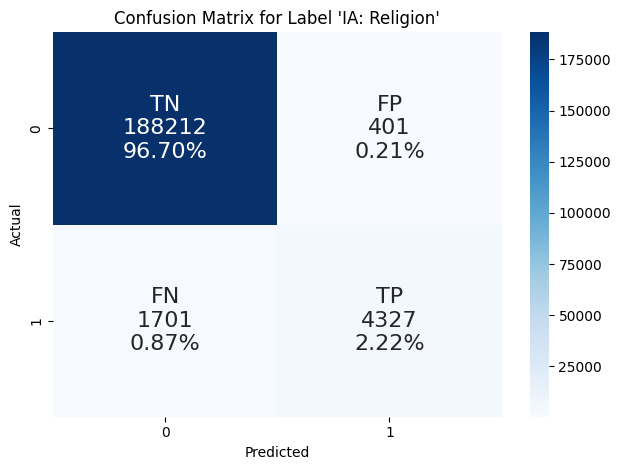

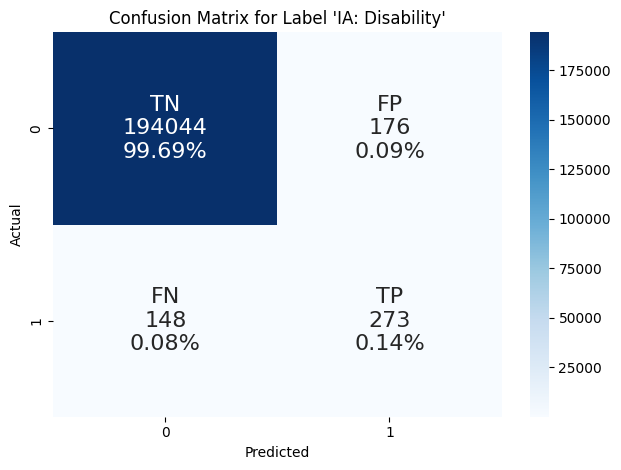

In [51]:

# Call the function to plot confusion matrices for all 12 labels
plot_confusion_matrices(true_labels, binary_predictions_pr_auc)

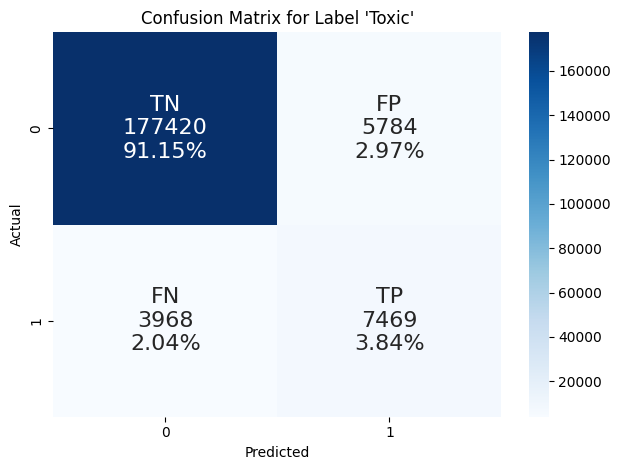

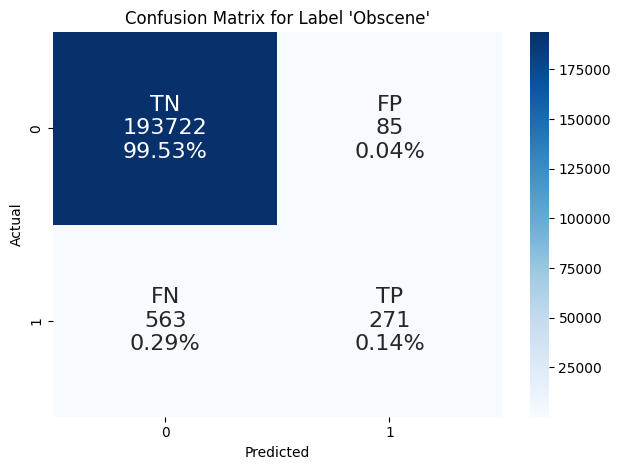

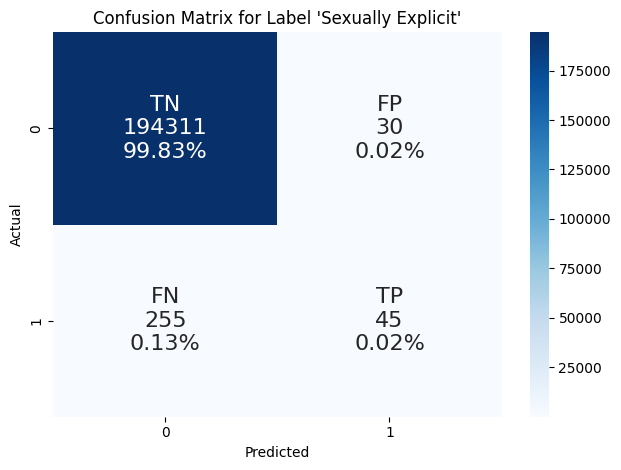

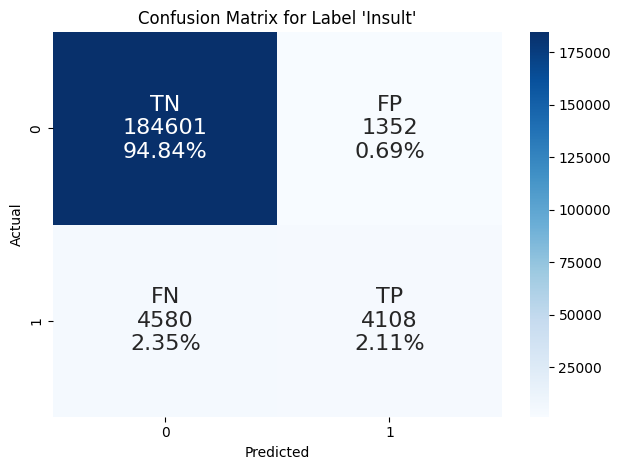

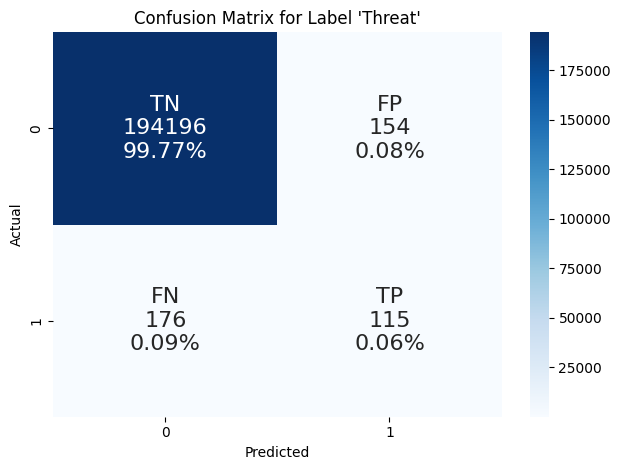

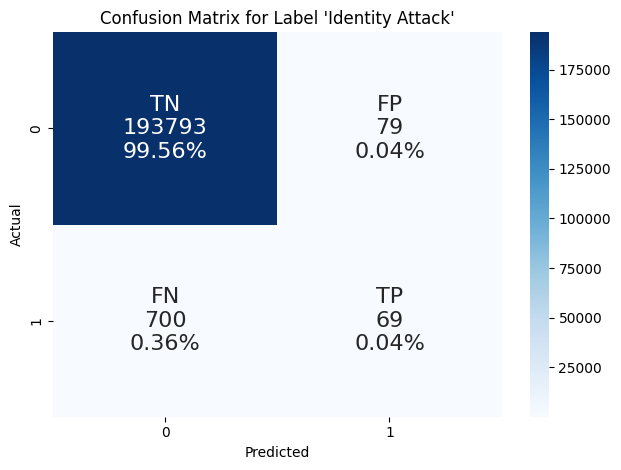

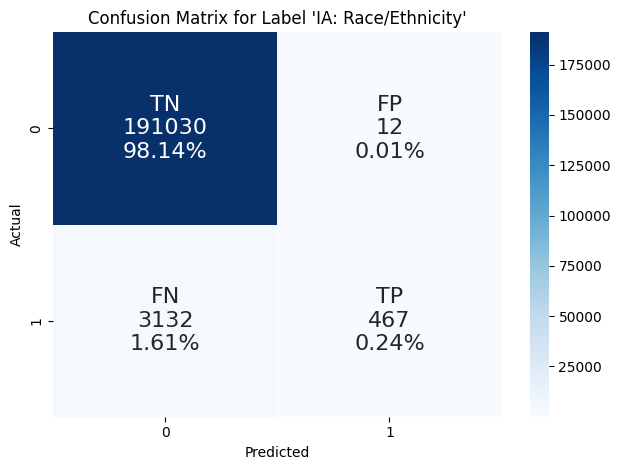

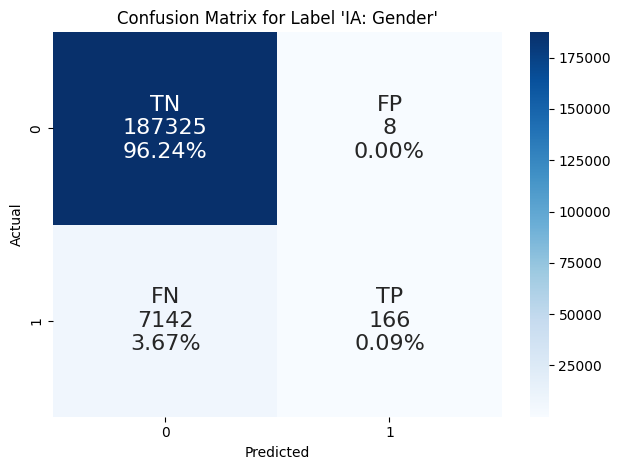

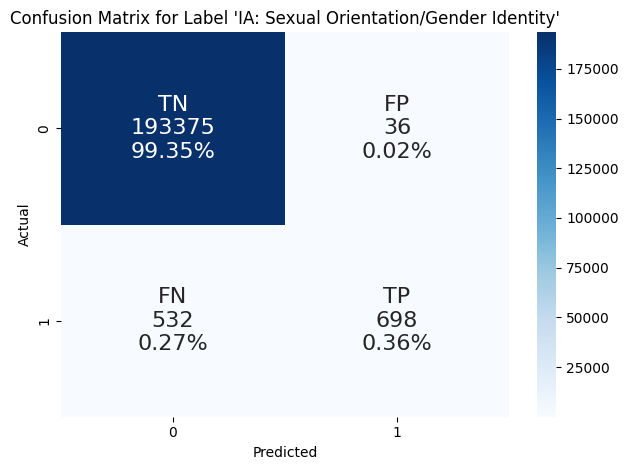

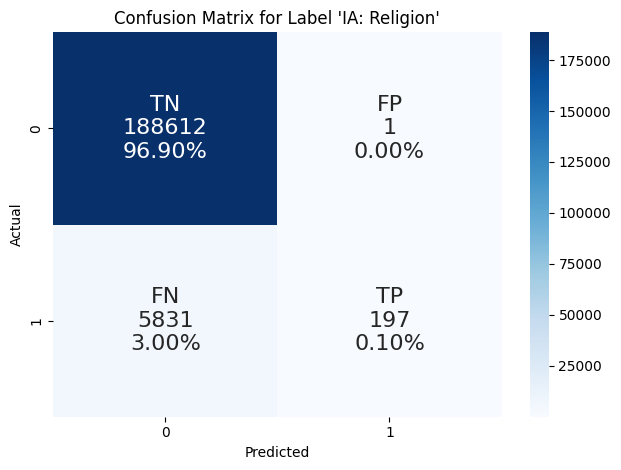

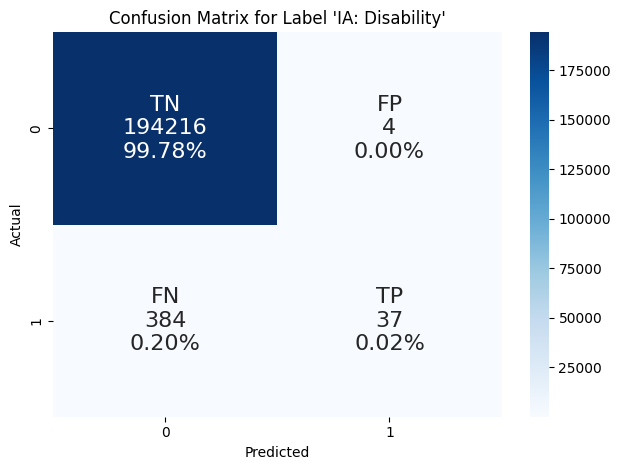

In [52]:
# Call the function to plot confusion matrices for all 12 labels
plot_confusion_matrices(true_labels, binary_predictions_precision)